In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

from treemind.algorithm import Explainer
from treemind.plot.plot_funcs import (
    feature_plot,
    interaction_plot,
)
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from typing import Tuple

from matplotlib.colors import TwoSlopeNorm

In [2]:
# Functions for plotting real data:
# - _set_common_style: Applies a consistent visual style to all plots to match the style used by TreeMind.
# - plot_line_chart: Creates a line chart to visualize trends in data over a continuous range.
# - plot_scatter_chart: Generates a scatter plot to explore relationships between two variables, with a third variable indicated by color.


def _set_common_style(ax, title):
    ax.set_facecolor("whitesmoke")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


def plot_line_chart(x, y, title, x_label, y_label, figsize: Tuple[int, int] = (10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=x, y=y, ax=ax, color="blue", linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    _set_common_style(ax, title)
    plt.tight_layout()
    plt.show()


def plot_scatter_chart(
    x, y, z, title, x_label, y_label, cbar_label, figsize: Tuple[int, int] = (10, 6)
):
    fig, ax = plt.subplots(figsize=figsize)

    if z.max() < 0:  # All values are negative
        colormap = plt.get_cmap("Blues")
        norm = plt.Normalize(vmin=z.min(), vmax=z.max())
    elif z.min() > 0:  # All values are positive
        colormap = plt.get_cmap("Reds")
        norm = plt.Normalize(vmin=z.min(), vmax=z.max())
    else:  # Both negative and positive values
        colormap = plt.get_cmap("coolwarm")
        norm = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max())

    scatter = ax.scatter(x, y, c=z, cmap=colormap, norm=norm, edgecolor="k")

    cbar = plt.colorbar(scatter, ax=ax)

    real_min = z.min()
    real_max = z.max()

    n_intervals = 10

    if real_min < 0 and real_max > 0:
        pos_ticks = np.linspace(0, real_max, n_intervals // 2 + 1)
        neg_ticks = np.linspace(real_min, 0, n_intervals // 2 + 1)[:-1]
        ticks = np.concatenate([neg_ticks, pos_ticks])
    else:
        ticks = np.linspace(real_min, real_max, n_intervals)

    # Colorbar'ı güncelle
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{x:.2f}" for x in ticks])
    cbar.set_label(cbar_label)

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    _set_common_style(ax, title)

    plt.tight_layout()
    plt.show()

In [3]:
n_samples = 10000

np.random.seed(42)  # Setting a random seed for reproducibility

# Base features with diverse probability distributions
feature_0 = np.random.gamma(shape=2, scale=2, size=n_samples)  # Gamma distribution
feature_1 = np.random.beta(2, 5, size=n_samples) * 10  # Beta distribution scaled
feature_2 = np.random.exponential(scale=1.5, size=n_samples)  # Exponential
feature_3 = np.random.chisquare(df=3, size=n_samples)  # Chi-square
feature_4 = np.random.weibull(1.5, size=n_samples)  # Weibull
feature_5 = np.random.normal(loc=2, scale=1.5, size=n_samples)  # Normal
feature_6 = np.random.uniform(low=-5, high=5, size=n_samples)  # Uniform
feature_7 = np.random.laplace(loc=0, scale=2, size=n_samples)  # Laplace
feature_8 = np.random.lognormal(mean=0, sigma=0.5, size=n_samples)  # Log-normal

# Complex non-linear transformations
transformed_0 = np.sin(feature_0) * np.exp(-feature_0/3) + feature_0**2/10
transformed_1 = np.where(feature_1 > 5, np.log1p(feature_1)**2, np.sqrt(feature_1))
transformed_2 = np.tanh(feature_2) * np.cos(np.pi * feature_2) + feature_2**3/20
transformed_3 = (1 / (1 + np.exp(-feature_3))) * np.log1p(feature_3)
transformed_4 = np.sinh(feature_4) / (1 + np.abs(feature_4)) + np.sqrt(feature_4)
transformed_5 = np.where(feature_5 > 0, 
                        np.log1p(np.abs(feature_5)) * np.sin(feature_5), 
                        np.log1p(np.abs(feature_5)) * np.cos(feature_5))
transformed_6 = np.cbrt(np.abs(feature_6)) * np.sign(feature_6) + feature_6**2/8
transformed_7 = np.exp(-np.abs(feature_7)) * np.sin(feature_7 * np.pi/4)
transformed_8 = np.log1p(feature_8) * np.tanh(feature_8/2)

# Binary interactions
interaction_0_1 = np.where(transformed_0 > transformed_1, transformed_0, transformed_1)
interaction_2_3 = transformed_2 * transformed_3 * np.sign(transformed_2 + transformed_3)
interaction_4_5 = np.maximum(transformed_4, transformed_5) * np.minimum(transformed_4, transformed_5)
interaction_6_7 = transformed_6 * np.sin(transformed_7)
interaction_7_8 = np.where(transformed_7 > 0, transformed_8, -transformed_8)

# Generated target with binary interactions
target = (
    0.4 * transformed_0
    - 0.6 * transformed_1
    + 0.3 * transformed_2
    + 0.5 * transformed_3
    - 0.4 * transformed_4
    + 0.7 * transformed_5
    - 0.3 * transformed_6
    + 0.5 * transformed_7
    - 0.4 * transformed_8
    + 0.6 * interaction_0_1
    - 0.5 * interaction_2_3
    + 0.4 * interaction_4_5
    - 0.3 * interaction_6_7
    + 0.5 * interaction_7_8
    + np.random.normal(loc=0, scale=0.2, size=n_samples)  # Biraz daha noise ekledim
)

# Add some outliers
outlier_idx = np.random.choice(n_samples, size=int(n_samples*0.01), replace=False)  # %1 outlier
target[outlier_idx] += np.random.normal(loc=0, scale=5, size=len(outlier_idx))

# Create DataFrame with all features
df = pd.DataFrame(
    {
        "feature_0": feature_0,  # Gamma
        "feature_1": feature_1,  # Beta
        "feature_2": feature_2,  # Exponential
        "feature_3": feature_3,  # Chi-square
        "feature_4": feature_4,  # Weibull
        "feature_5": feature_5,  # Normal
        "feature_6": feature_6,  # Uniform
        "feature_7": feature_7,  # Laplace
        "feature_8": feature_8,  # Log-normal
        "target": target,
    }
)

# Split the data into features (X) and target (y)
X = df.drop("target", axis=1).values
y = df["target"].values

In [4]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1, n_estimators=500, num_leaves=75, learning_rate=0.02)
reg.fit(X, y)  #

# Use treemind's Explainer to analyze the trained model
explainer = Explainer()
explainer(reg)

# Use shap's TreeExplainer to analyze the trained model
shap_explainer = shap.TreeExplainer(reg)
shap_values = shap_explainer(X)
shap_interaction_values = shap_explainer.shap_interaction_values(X)

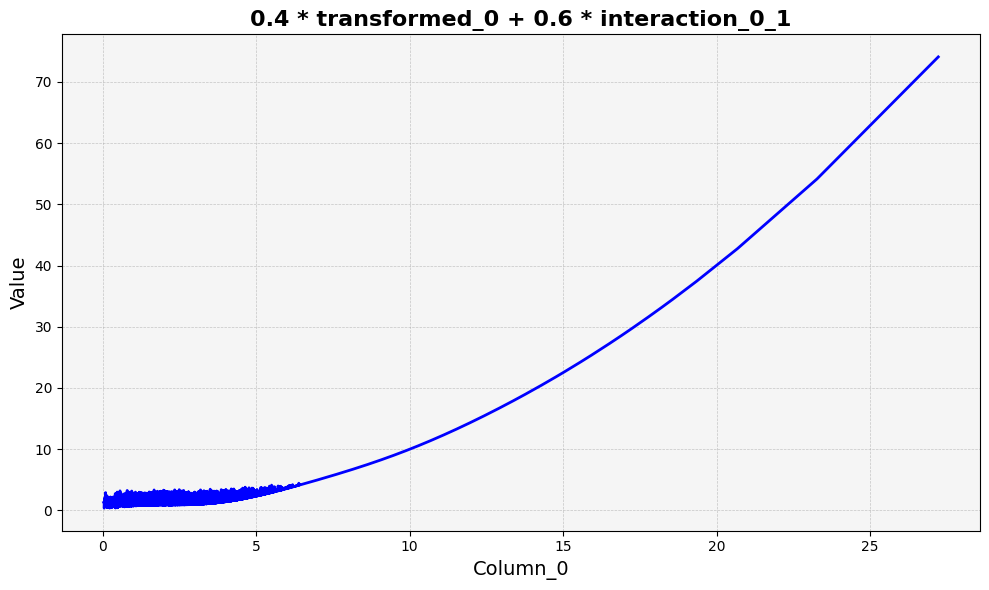

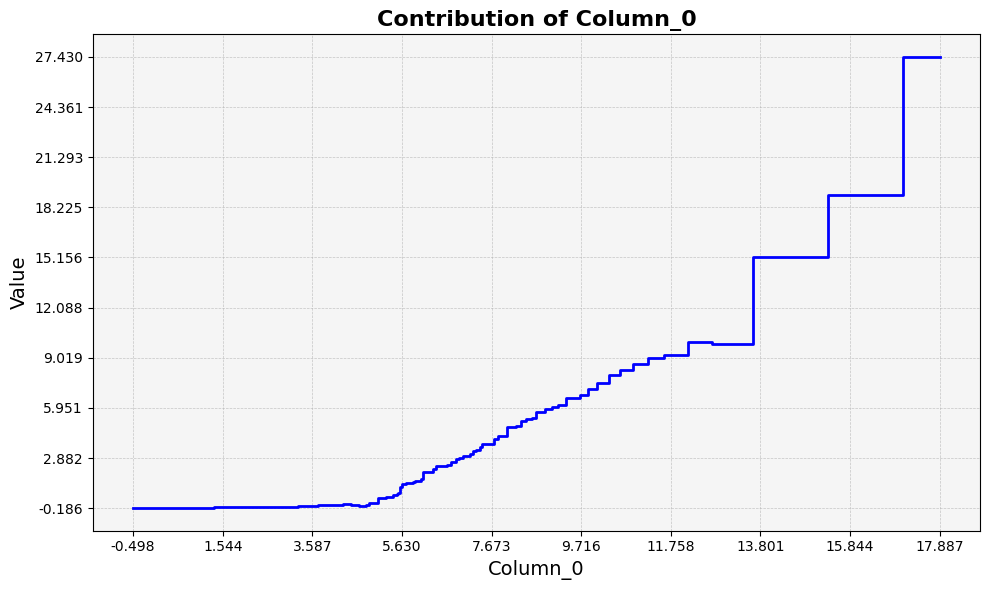

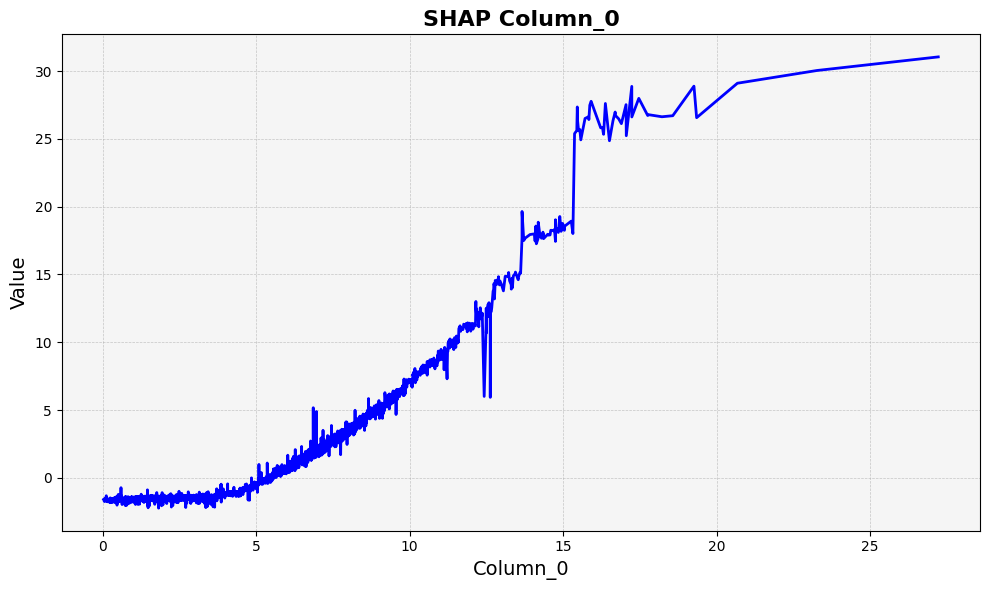

In [5]:
# Feature 0 Analysis
feature_df_0 = explainer.analyze_feature(0)
plot_line_chart(
    x=feature_0,
    y=0.4 * transformed_0 + 0.6 * interaction_0_1,
    x_label="Column_0",
    y_label="Value",
    title="0.4 * transformed_0 + 0.6 * interaction_0_1",
)
feature_plot(feature_df_0, show_min_max=False)
plot_line_chart(
    x=feature_0,
    y=shap_values.values[:, 0],
    x_label="Column_0",
    y_label="Value",
    title="SHAP Column_0",
)

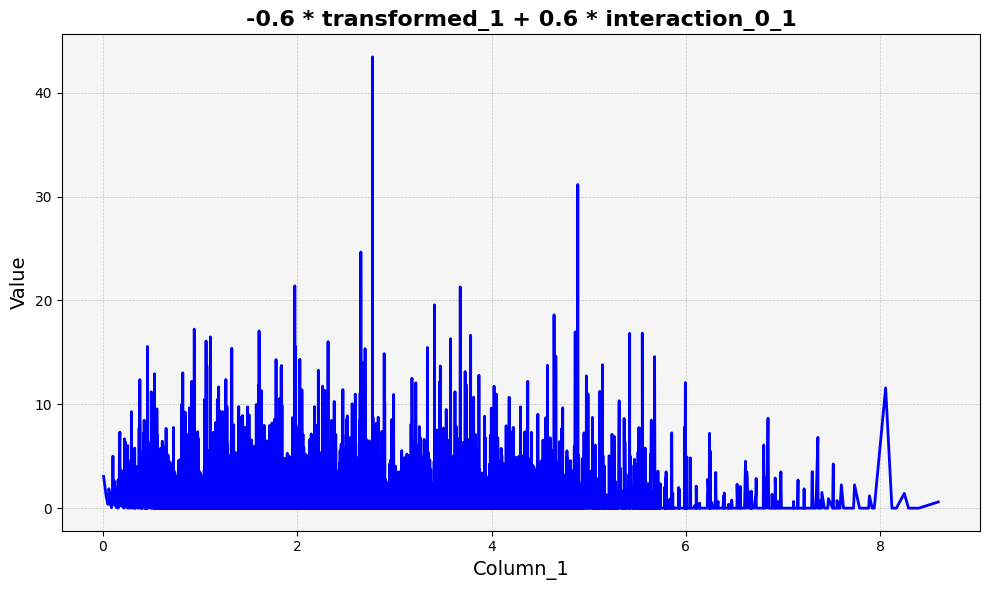

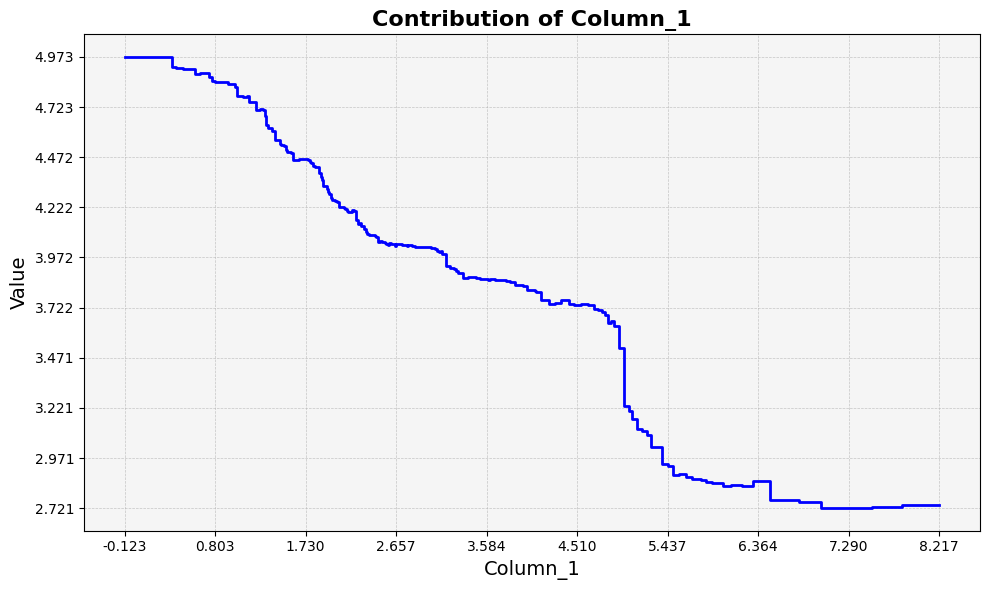

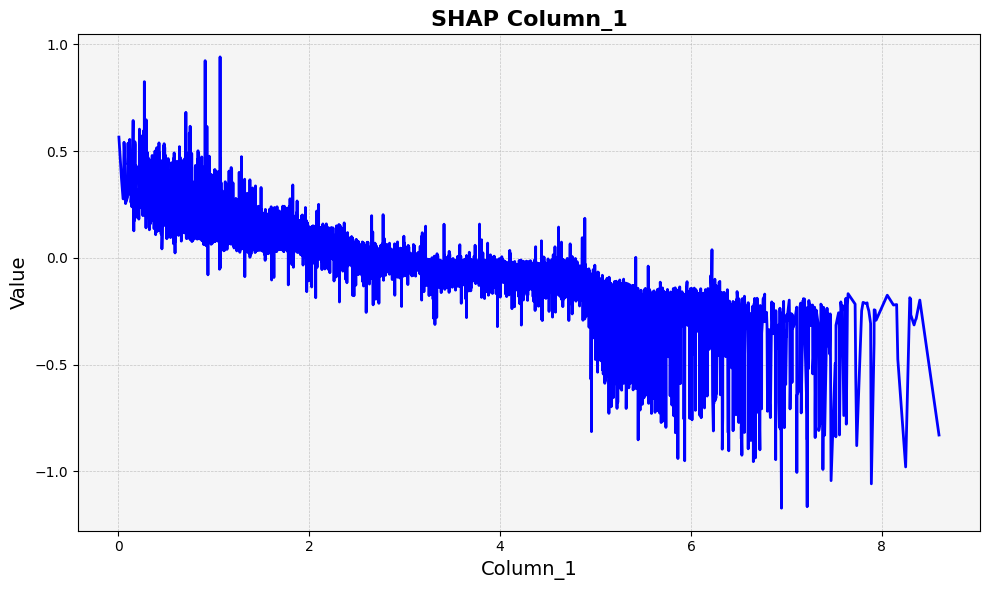

In [6]:

# Feature 1 Analysis
feature_df_1 = explainer.analyze_feature(1)
plot_line_chart(
    x=feature_1,
    y=-0.6 * transformed_1 + 0.6 * interaction_0_1,
    x_label="Column_1",
    y_label="Value",
    title="-0.6 * transformed_1 + 0.6 * interaction_0_1",
)
feature_plot(feature_df_1, show_min_max=False)
plot_line_chart(
    x=feature_1,
    y=shap_values.values[:, 1],
    x_label="Column_1",
    y_label="Value",
    title="SHAP Column_1",
)

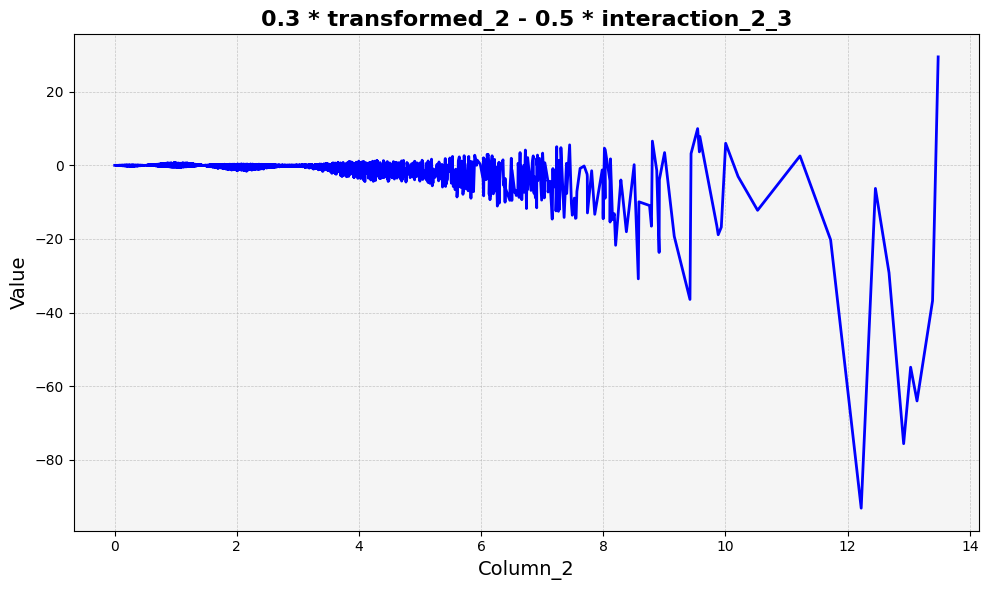

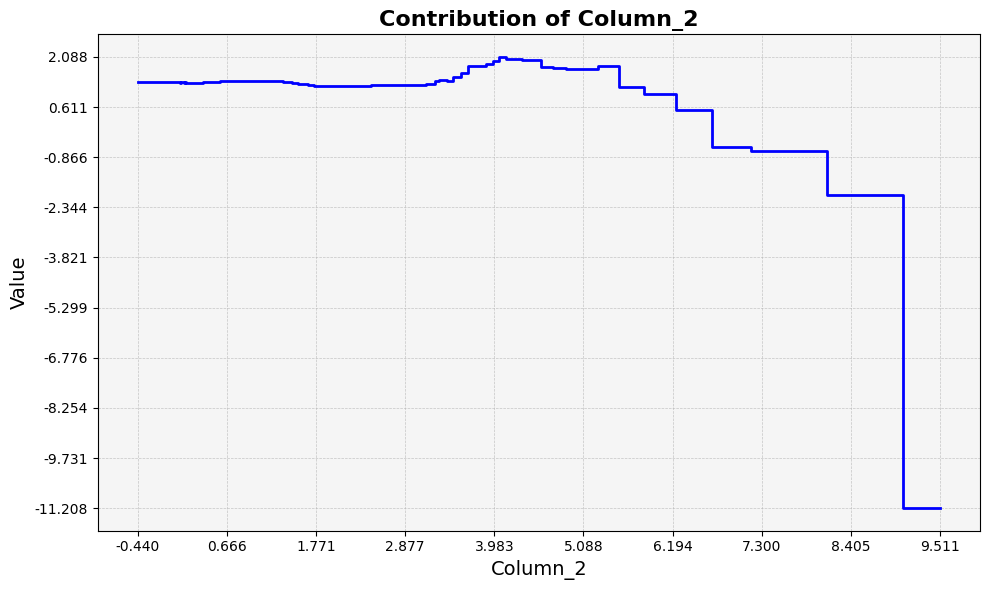

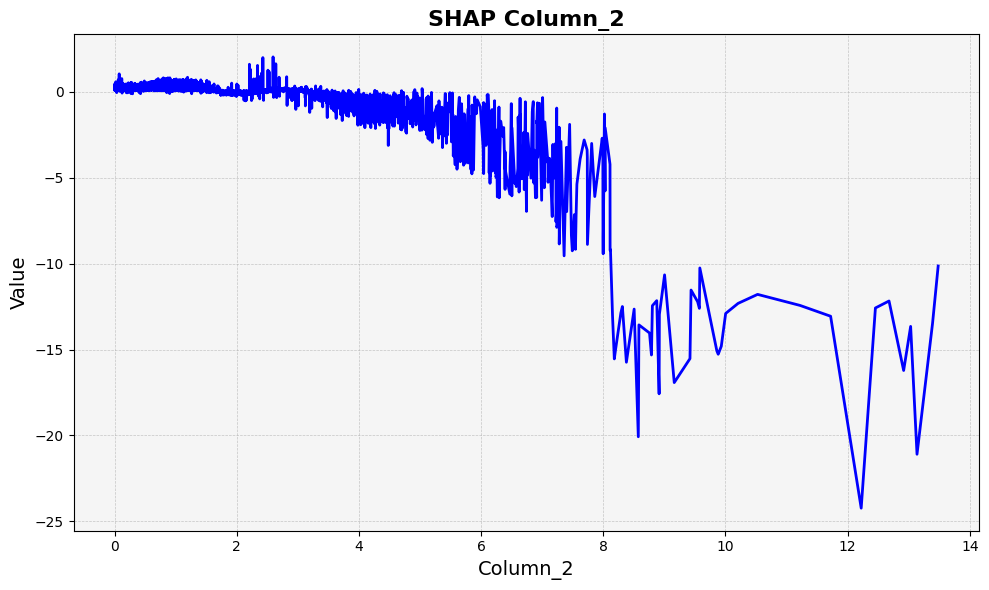

In [7]:

# Feature 2 Analysis
feature_df_2 = explainer.analyze_feature(2)
plot_line_chart(
    x=feature_2,
    y=0.3 * transformed_2 - 0.5 * interaction_2_3,
    x_label="Column_2",
    y_label="Value",
    title="0.3 * transformed_2 - 0.5 * interaction_2_3",
)
feature_plot(feature_df_2, show_min_max=False)
plot_line_chart(
    x=feature_2,
    y=shap_values.values[:, 2],
    x_label="Column_2",
    y_label="Value",
    title="SHAP Column_2",
)

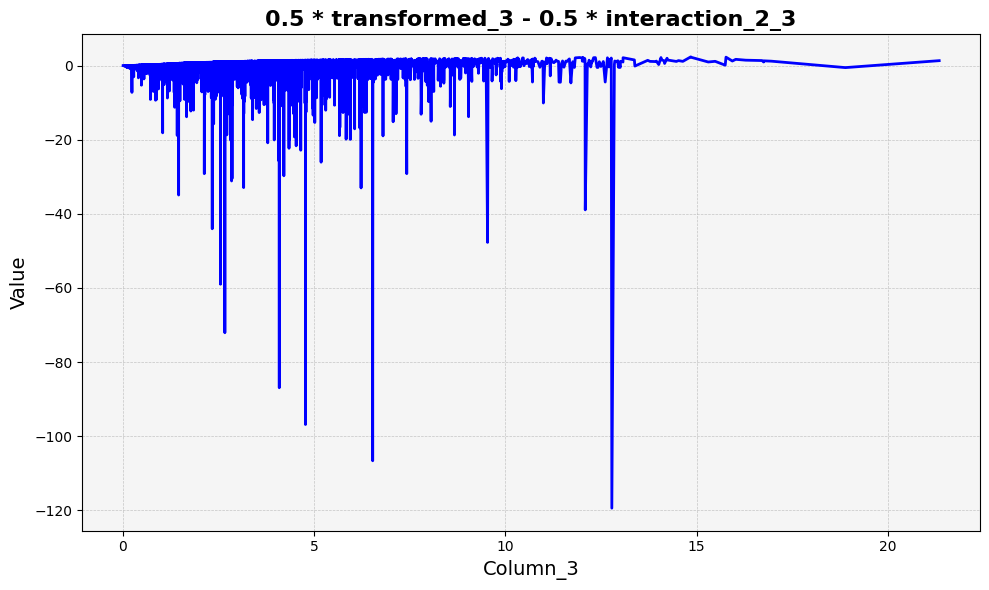

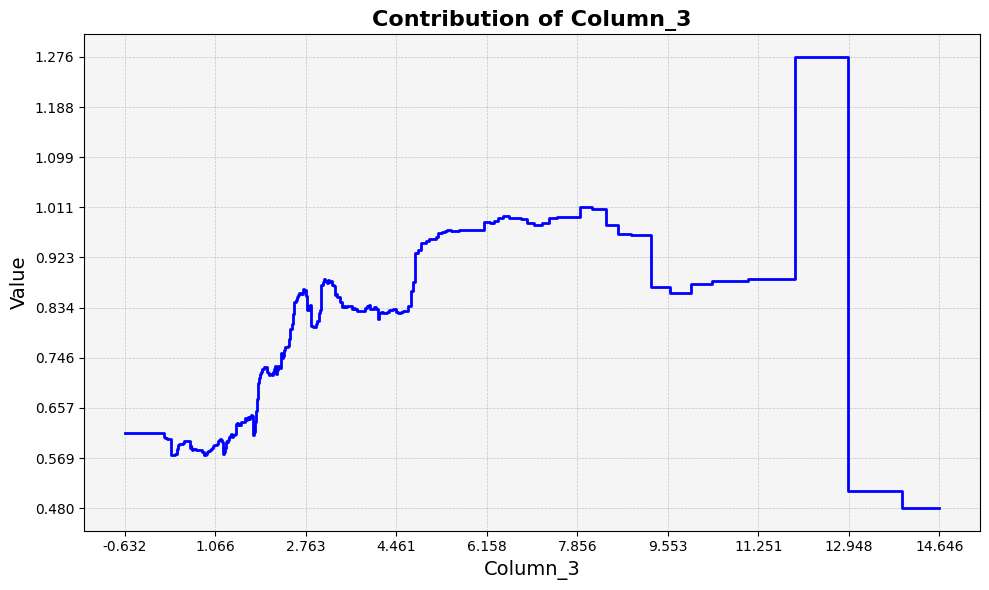

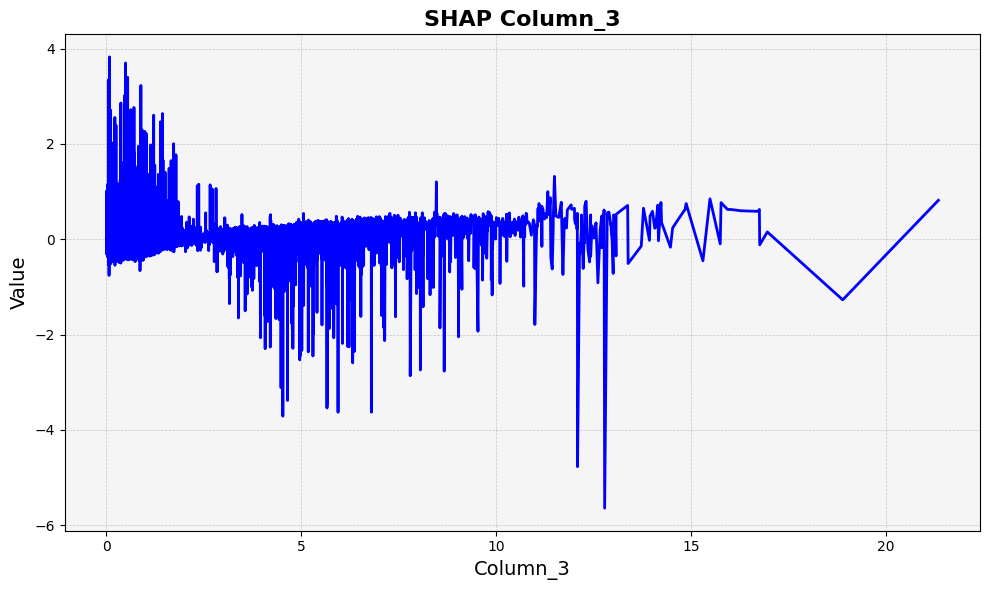

In [8]:
# Feature 3 Analysis
feature_df_3 = explainer.analyze_feature(3)
plot_line_chart(
    x=feature_3,
    y=0.5 * transformed_3 - 0.5 * interaction_2_3,
    x_label="Column_3",
    y_label="Value",
    title="0.5 * transformed_3 - 0.5 * interaction_2_3",
)
feature_plot(feature_df_3, show_min_max=False)
plot_line_chart(
    x=feature_3,
    y=shap_values.values[:, 3],
    x_label="Column_3",
    y_label="Value",
    title="SHAP Column_3",
)

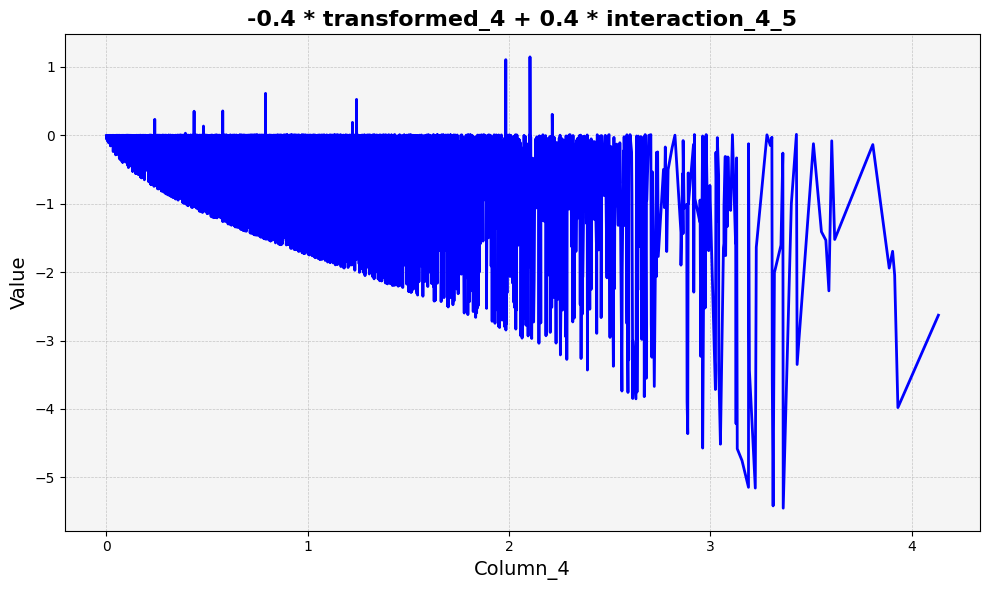

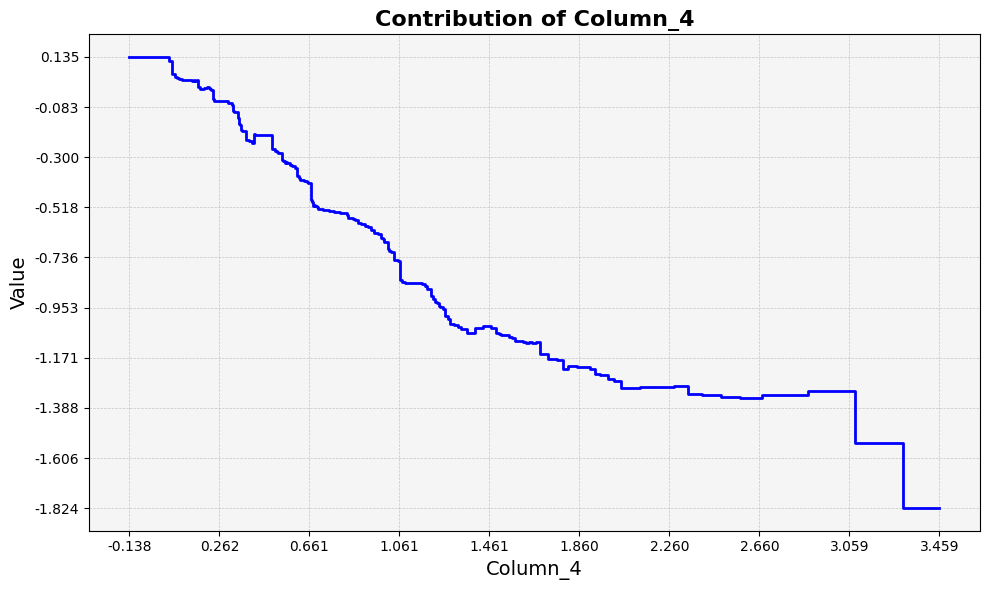

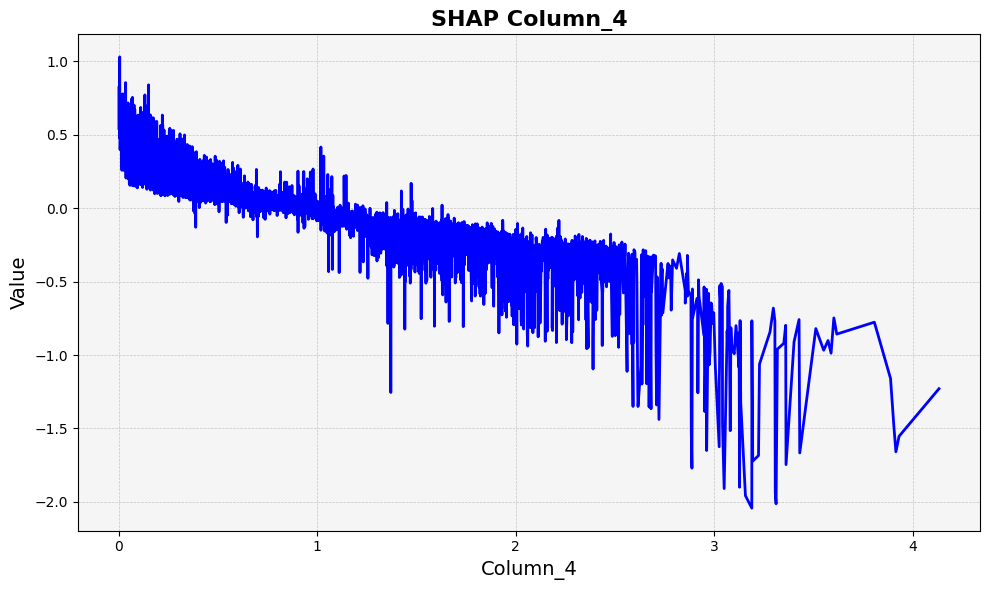

In [9]:
# Feature 4 Analysis
feature_df_4 = explainer.analyze_feature(4)
plot_line_chart(
    x=feature_4,
    y=-0.4 * transformed_4 + 0.4 * interaction_4_5,
    x_label="Column_4",
    y_label="Value",
    title="-0.4 * transformed_4 + 0.4 * interaction_4_5",
)
feature_plot(feature_df_4, show_min_max=False)
plot_line_chart(
    x=feature_4,
    y=shap_values.values[:, 4],
    x_label="Column_4",
    y_label="Value",
    title="SHAP Column_4",
)

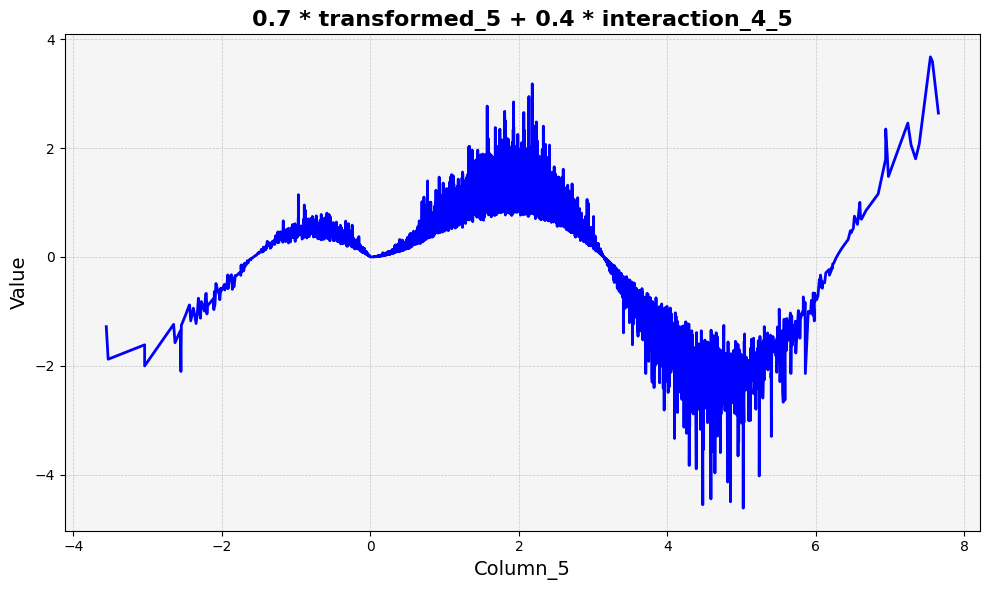

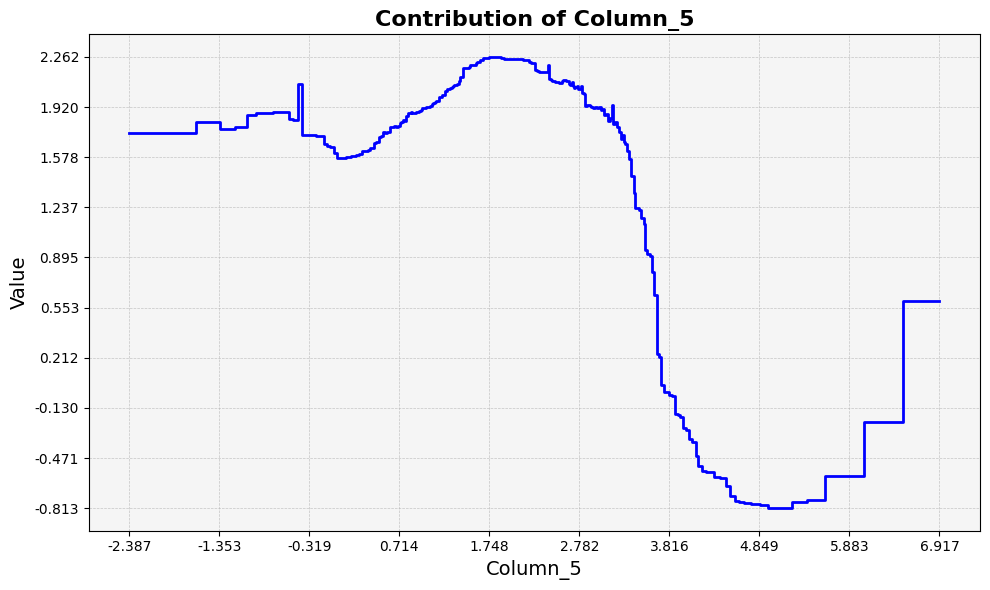

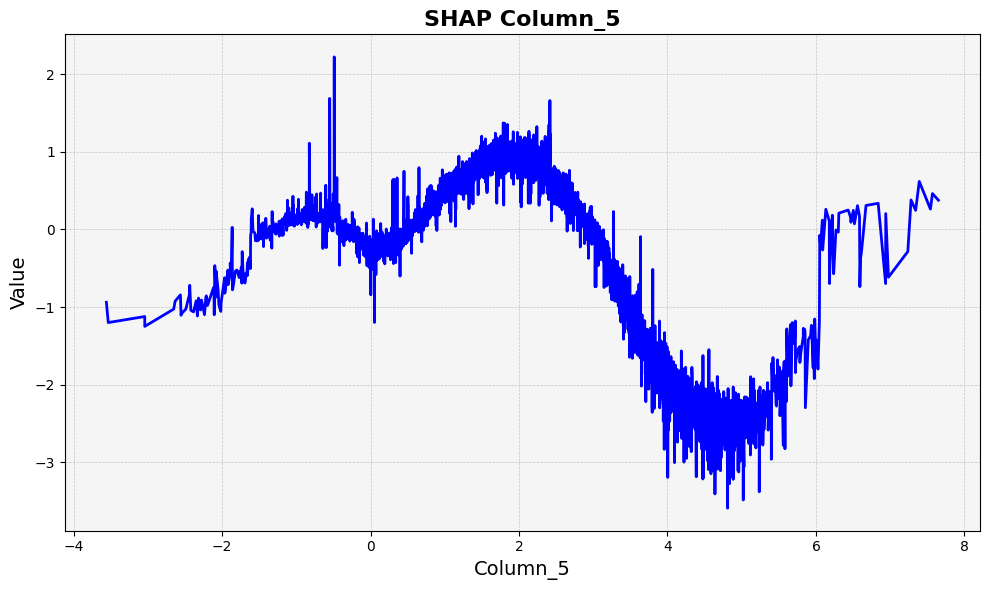

In [10]:
# Feature 5 Analysis
feature_df_5 = explainer.analyze_feature(5)
plot_line_chart(
    x=feature_5,
    y=0.7 * transformed_5 + 0.4 * interaction_4_5,
    x_label="Column_5",
    y_label="Value",
    title="0.7 * transformed_5 + 0.4 * interaction_4_5",
)
feature_plot(feature_df_5, show_min_max=False)
plot_line_chart(
    x=feature_5,
    y=shap_values.values[:, 5],
    x_label="Column_5",
    y_label="Value",
    title="SHAP Column_5",
)


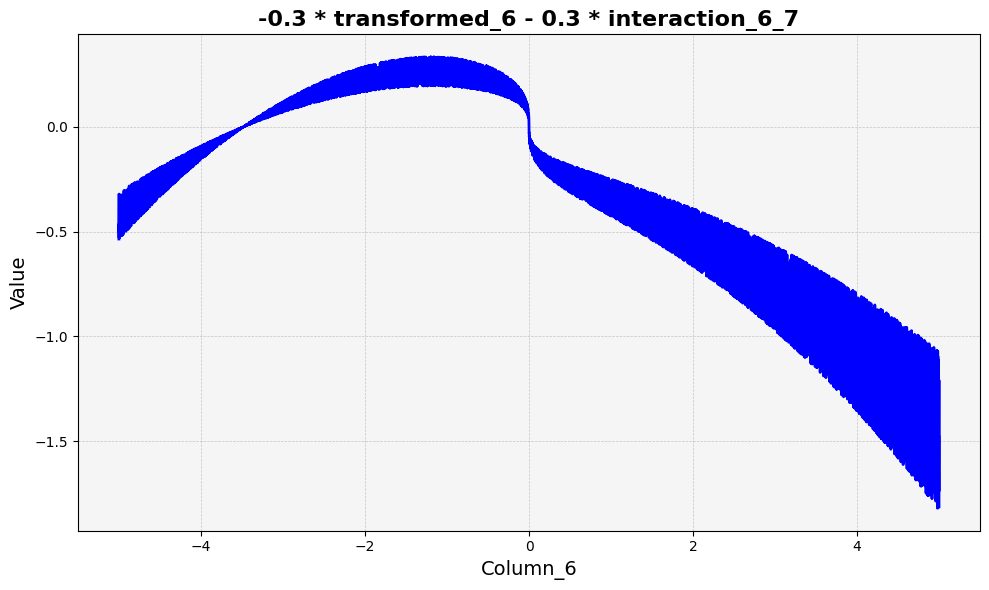

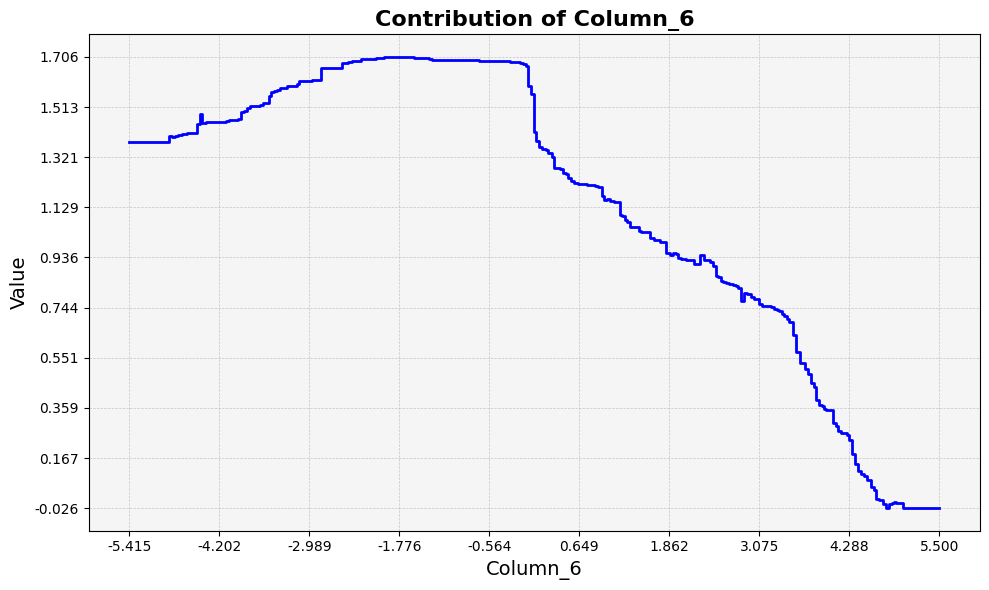

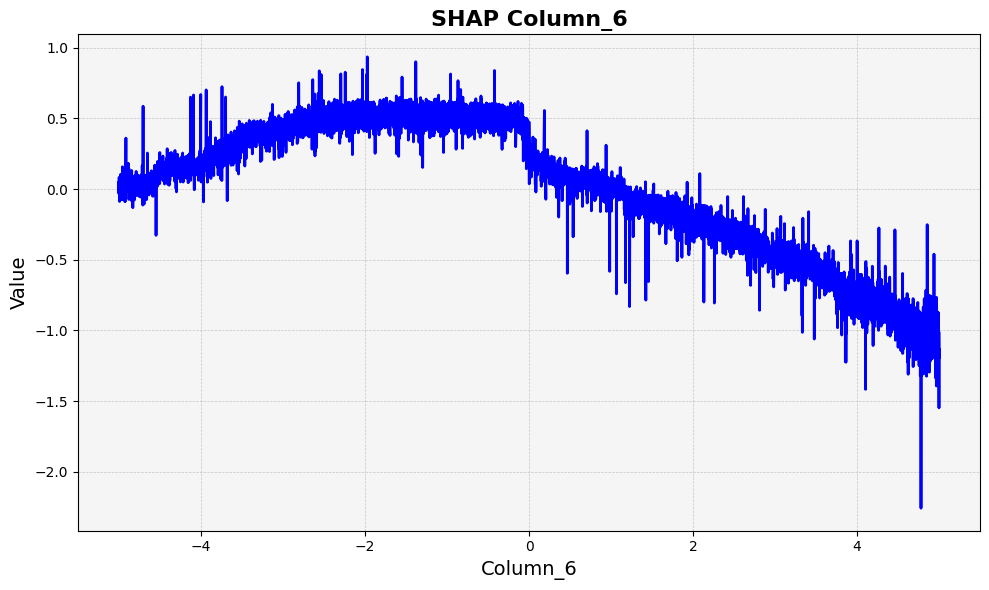

In [22]:
# Feature 6 Analysis
feature_df_6 = explainer.analyze_feature(6)
plot_line_chart(
    x=feature_6,
    y=-0.3 * transformed_6 - 0.3 * interaction_6_7,
    x_label="Column_6",
    y_label="Value",
    title="-0.3 * transformed_6 - 0.3 * interaction_6_7",
)
feature_plot(feature_df_6, show_min_max=False)
plot_line_chart(
    x=feature_6,
    y=shap_values.values[:, 6],
    x_label="Column_6",
    y_label="Value",
    title="SHAP Column_6",
)

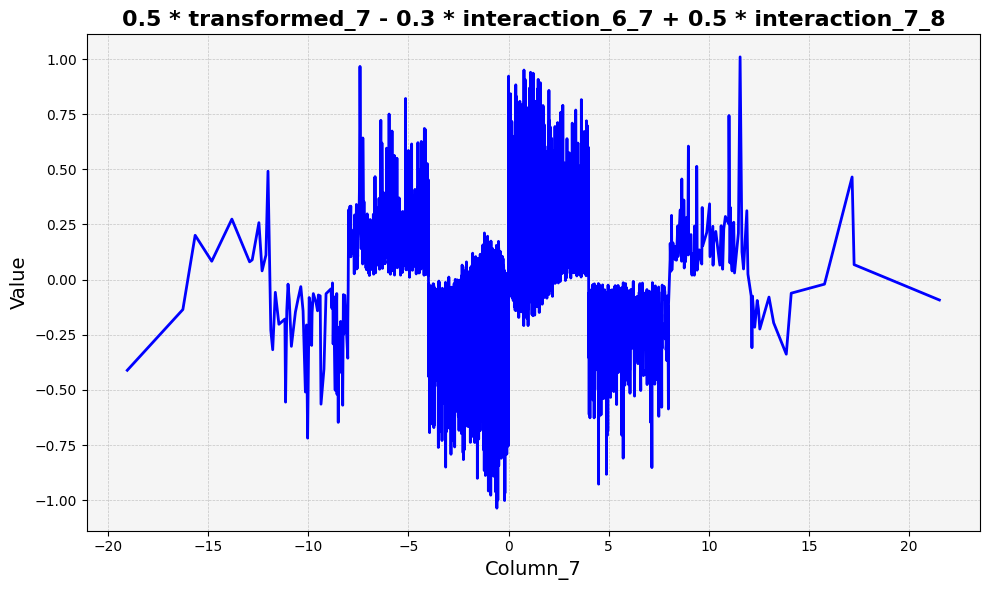

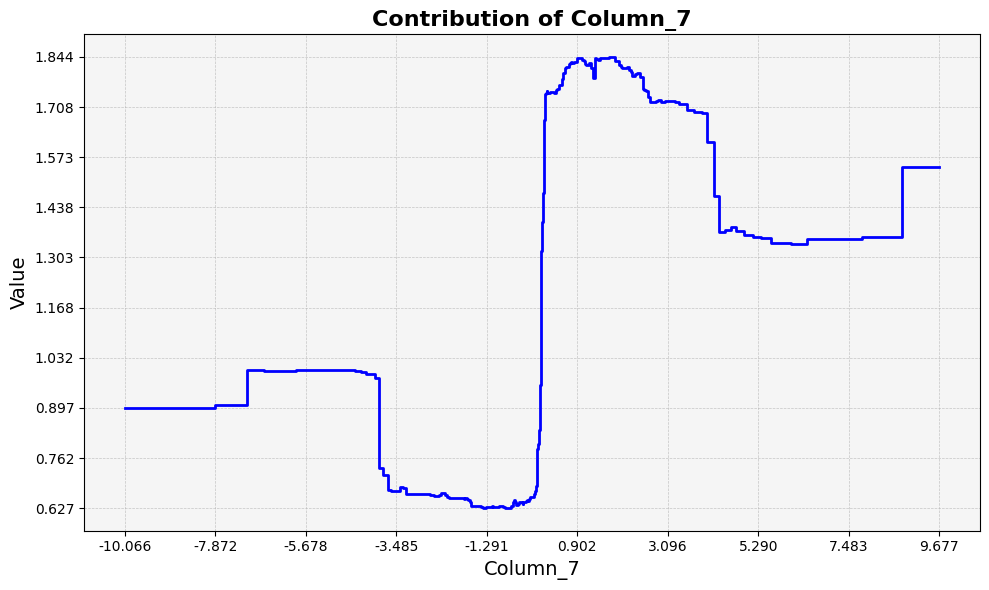

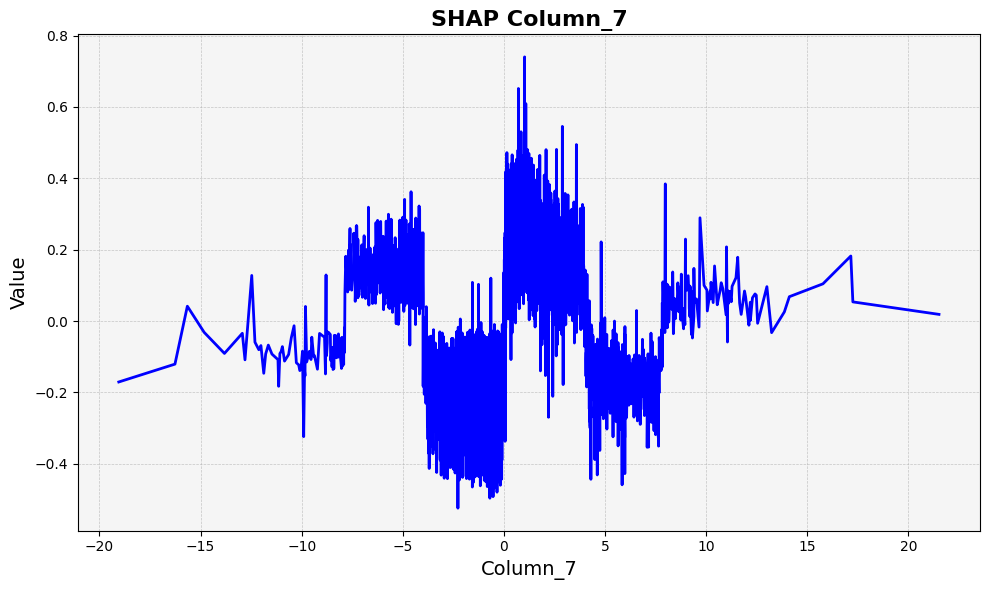

In [20]:
# Feature 7 Analysis
feature_df_7 = explainer.analyze_feature(7)
plot_line_chart(
    x=feature_7,
    y=0.5 * transformed_7 - 0.3 * interaction_6_7 + 0.5 * interaction_7_8,
    x_label="Column_7",
    y_label="Value",
    title="0.5 * transformed_7 - 0.3 * interaction_6_7 + 0.5 * interaction_7_8",
)
feature_plot(feature_df_7, show_min_max=False)
plot_line_chart(
    x=feature_7,
    y=shap_values.values[:, 7],
    x_label="Column_7",
    y_label="Value",
    title="SHAP Column_7",
)


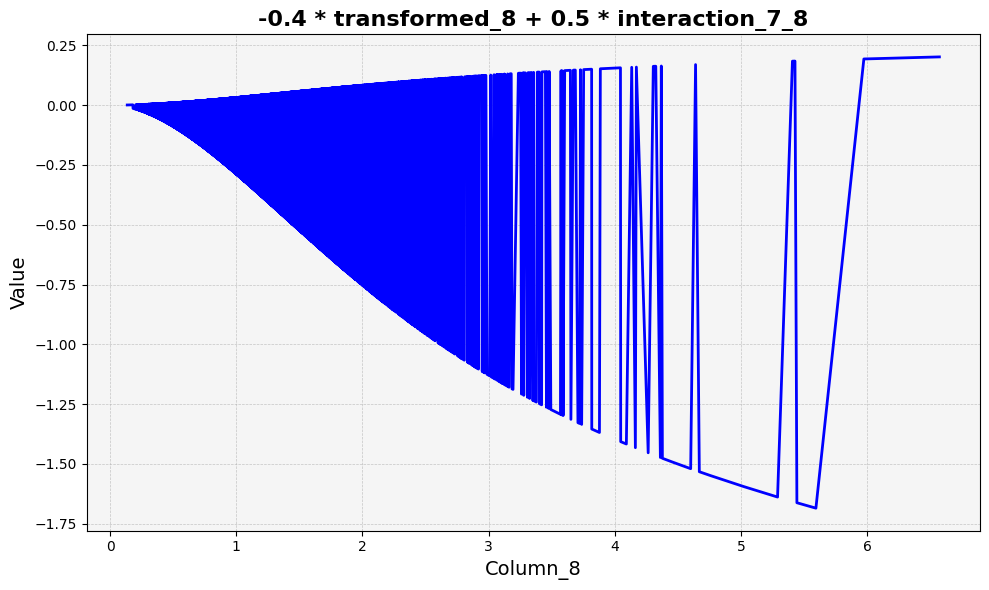

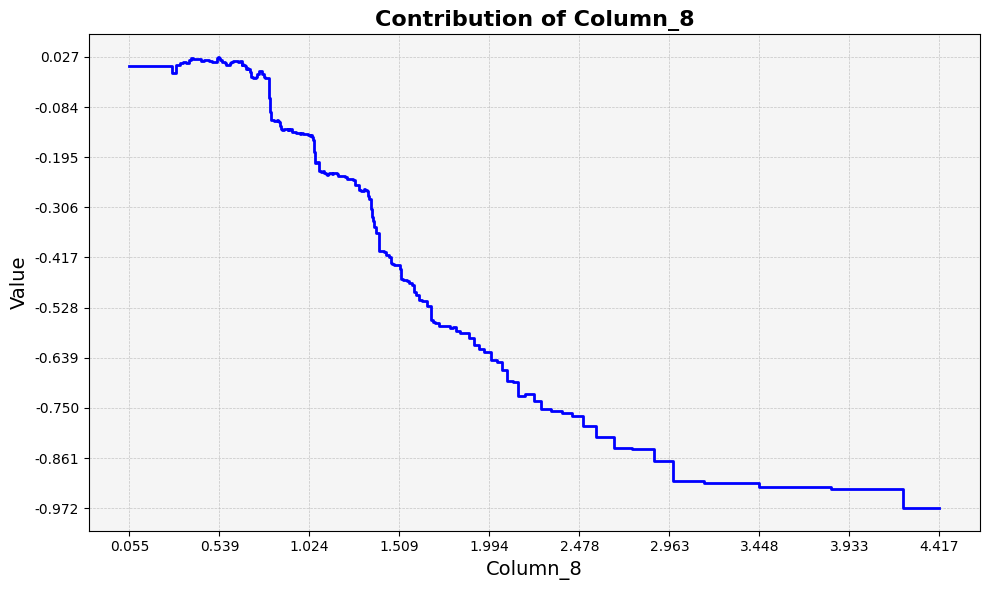

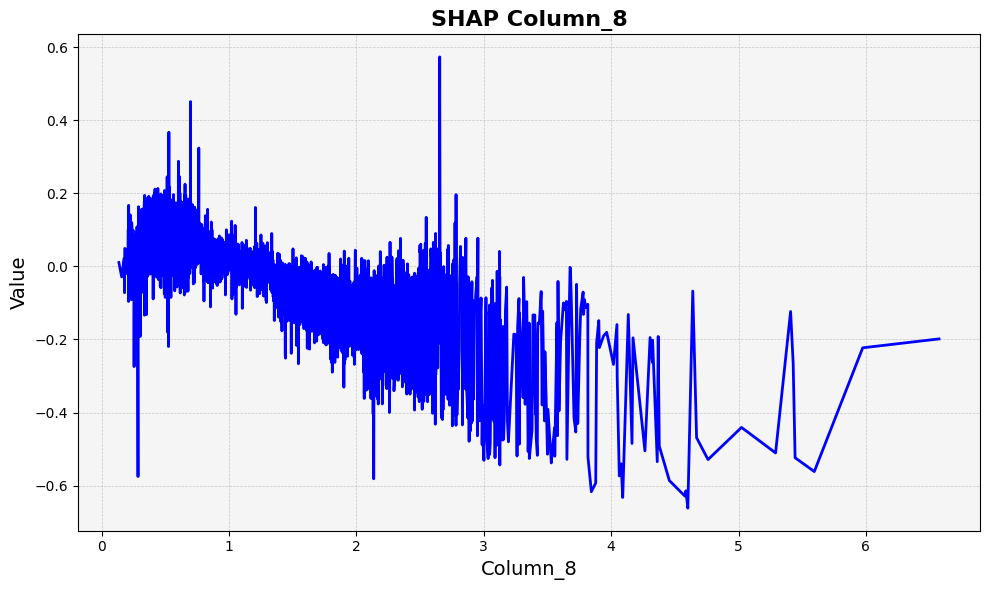

In [13]:
# Feature 8 Analysis
feature_df_8 = explainer.analyze_feature(8)
plot_line_chart(
    x=feature_8,
    y=-0.4 * transformed_8 + 0.5 * interaction_7_8,
    x_label="Column_8",
    y_label="Value",
    title="-0.4 * transformed_8 + 0.5 * interaction_7_8",
)
feature_plot(feature_df_8, show_min_max=False)
plot_line_chart(
    x=feature_8,
    y=shap_values.values[:, 8],
    x_label="Column_8",
    y_label="Value",
    title="SHAP Column_8",
)

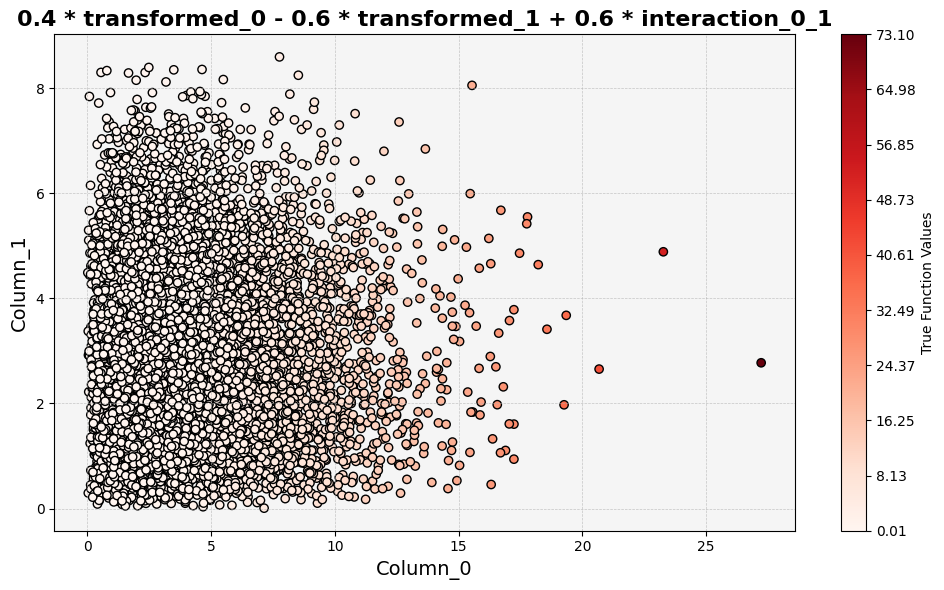

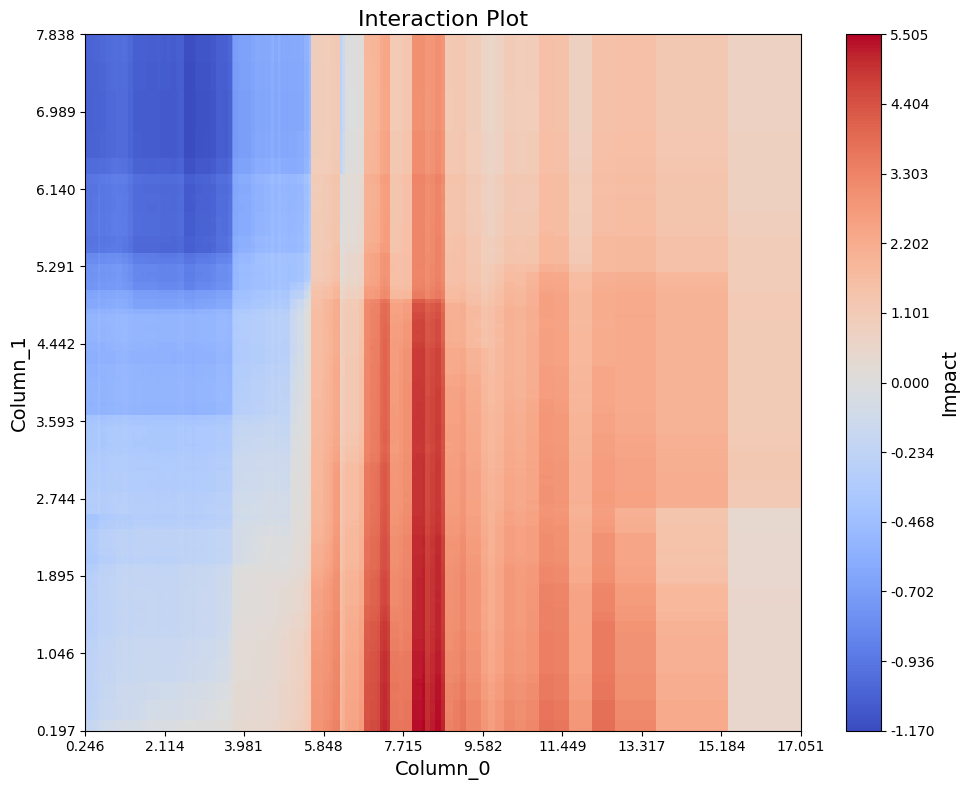

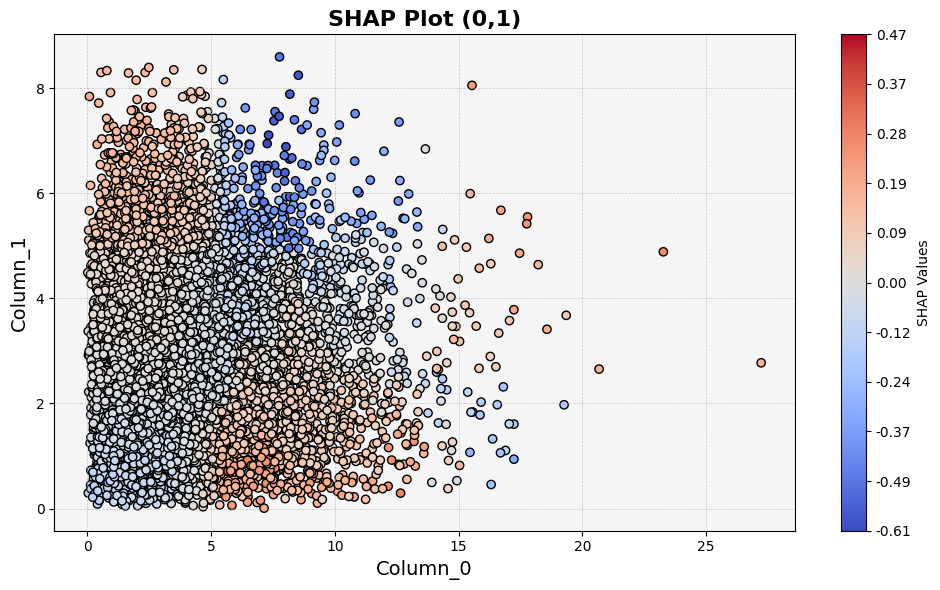

In [14]:
# Interaction Analysis: Feature 0 & Feature 1
df_01 = explainer.analyze_interaction(0, 1)
plot_scatter_chart(
    feature_0,
    feature_1,
    0.4 * transformed_0 - 0.6 * transformed_1 + 0.6 * interaction_0_1,
    x_label="Column_0",
    y_label="Column_1",
    title="0.4 * transformed_0 - 0.6 * transformed_1 + 0.6 * interaction_0_1",
    cbar_label="True Function Values",
)
interaction_plot(df_01)
plot_scatter_chart(
    feature_0,
    feature_1,
    shap_interaction_values[:, 0, 1],
    x_label="Column_0",
    y_label="Column_1",
    title="SHAP Plot (0,1)",
    cbar_label="SHAP Values",
)

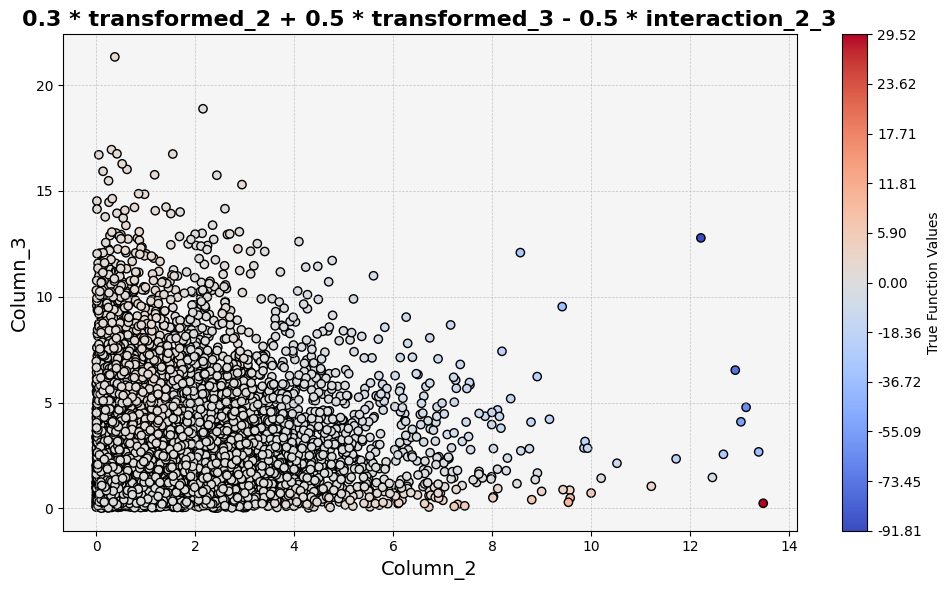

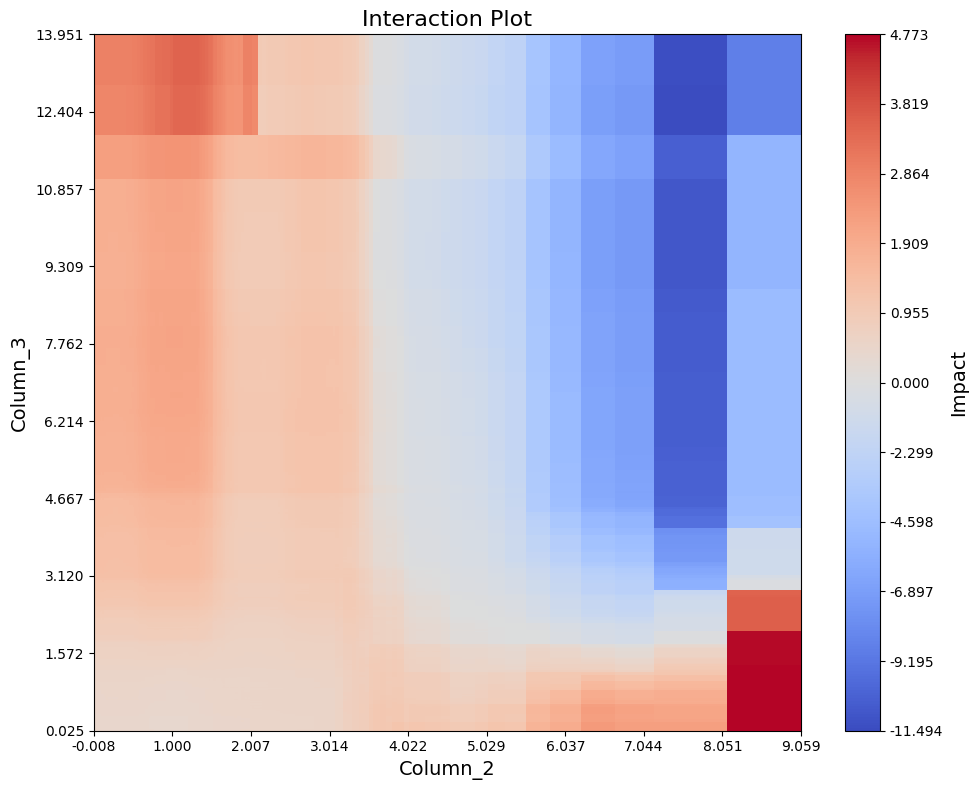

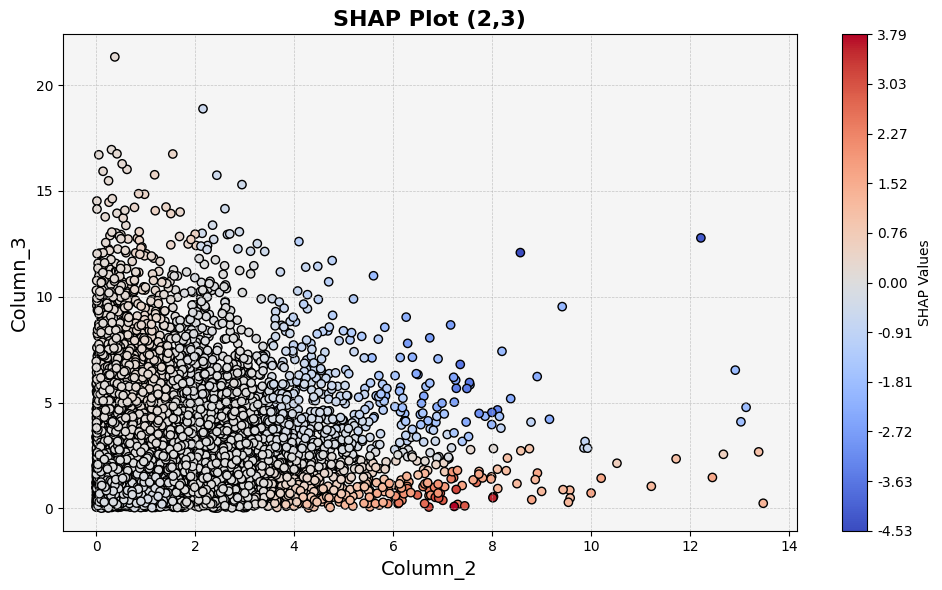

In [15]:

# Interaction Analysis: Feature 2 & Feature 3
df_23 = explainer.analyze_interaction(2, 3)
plot_scatter_chart(
    feature_2,
    feature_3,
    0.3 * transformed_2 + 0.5 * transformed_3 - 0.5 * interaction_2_3,
    x_label="Column_2",
    y_label="Column_3",
    title="0.3 * transformed_2 + 0.5 * transformed_3 - 0.5 * interaction_2_3",
    cbar_label="True Function Values",
)
interaction_plot(df_23)
plot_scatter_chart(
    feature_2,
    feature_3,
    shap_interaction_values[:, 2, 3],
    x_label="Column_2",
    y_label="Column_3",
    title="SHAP Plot (2,3)",
    cbar_label="SHAP Values",
)

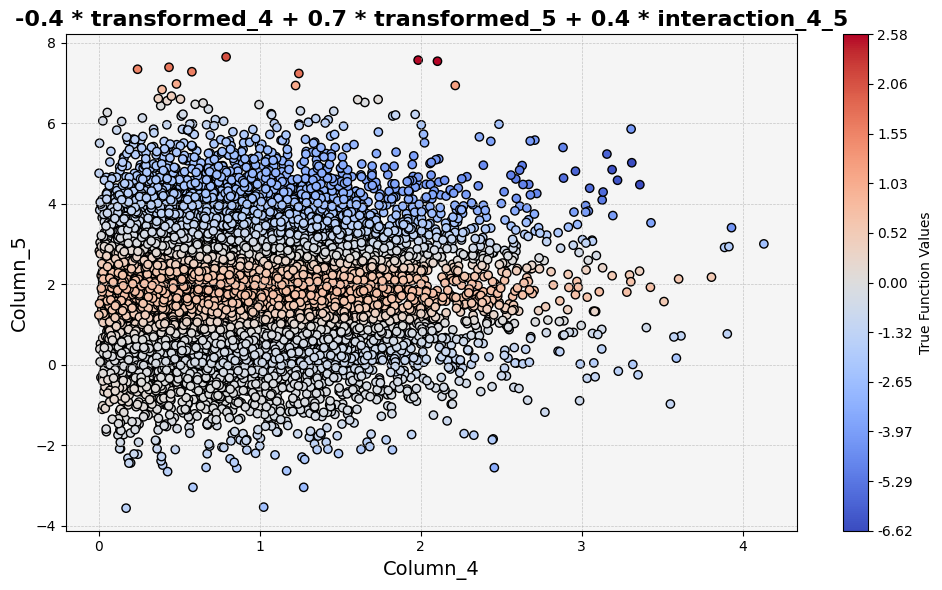

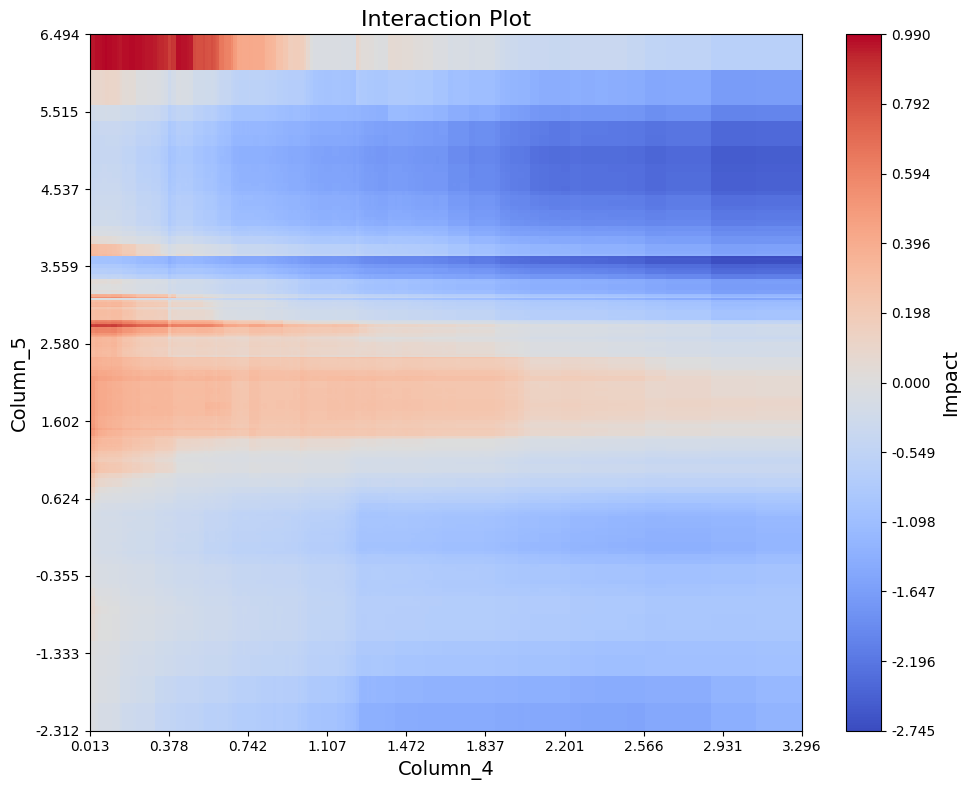

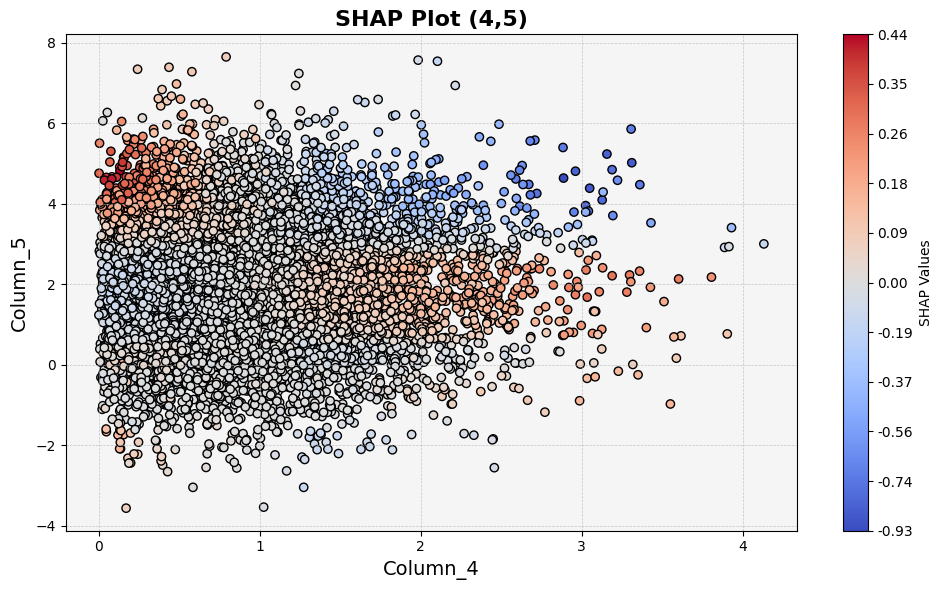

In [16]:

# Interaction Analysis: Feature 4 & Feature 5
df_45 = explainer.analyze_interaction(4, 5)
plot_scatter_chart(
    feature_4,
    feature_5,
    -0.4 * transformed_4 + 0.7 * transformed_5 + 0.4 * interaction_4_5,
    x_label="Column_4",
    y_label="Column_5",
    title="-0.4 * transformed_4 + 0.7 * transformed_5 + 0.4 * interaction_4_5",
    cbar_label="True Function Values",
)
interaction_plot(df_45)
plot_scatter_chart(
    feature_4,
    feature_5,
    shap_interaction_values[:, 4, 5],
    x_label="Column_4",
    y_label="Column_5",
    title="SHAP Plot (4,5)",
    cbar_label="SHAP Values",
)

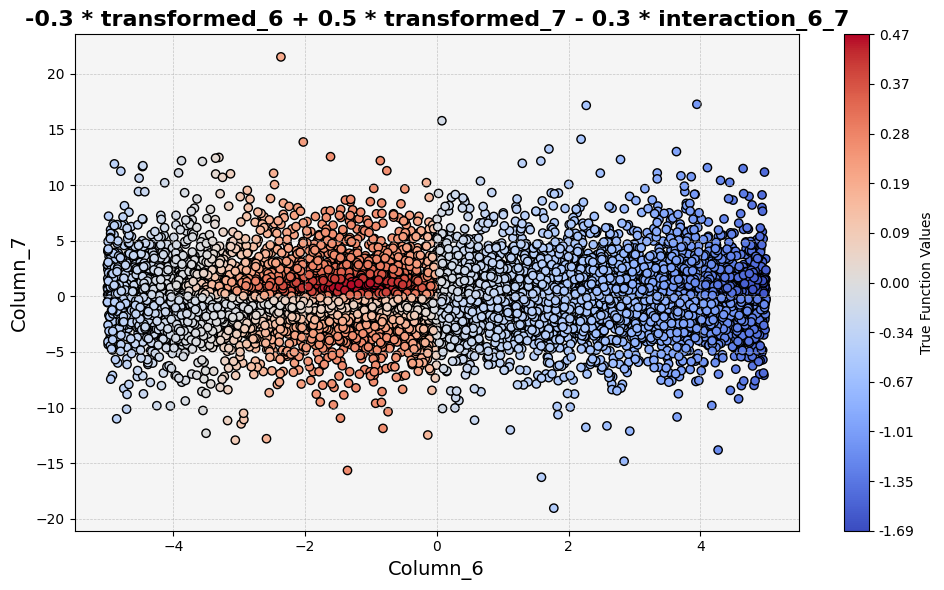

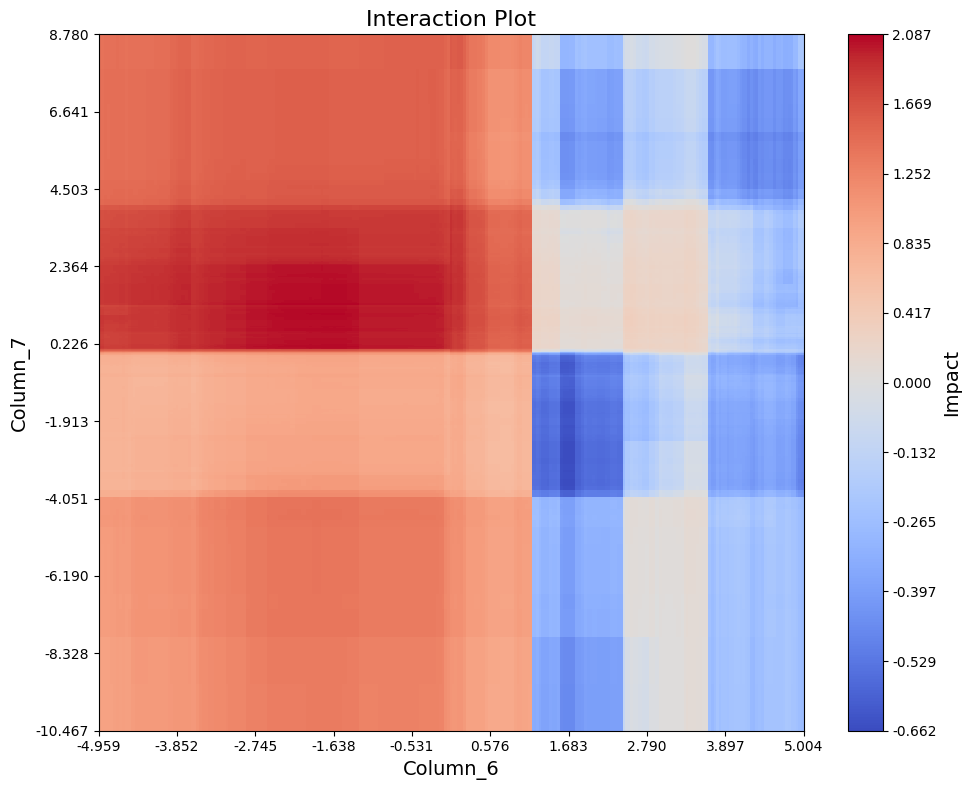

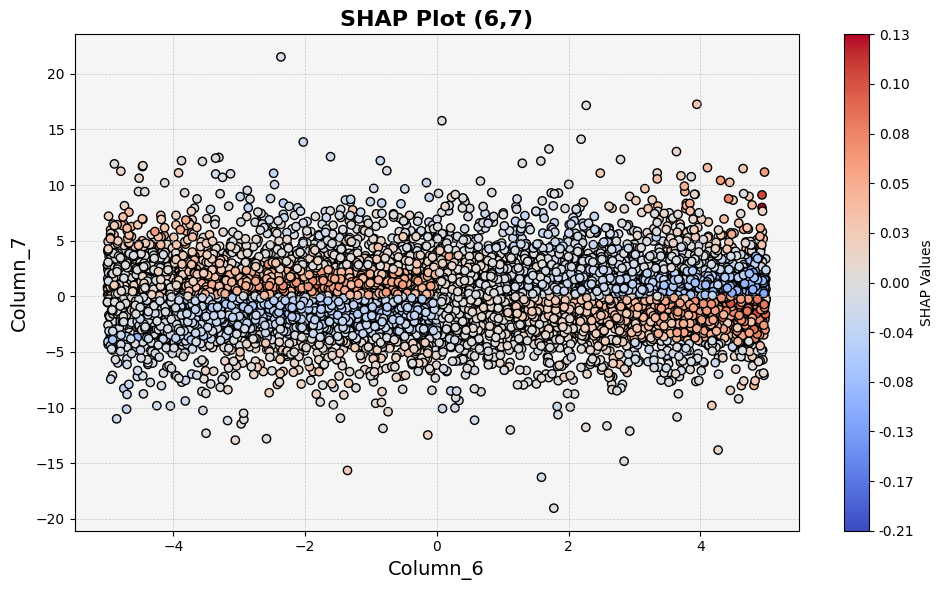

In [17]:
# Interaction Analysis: Feature 6 & Feature 7
df_67 = explainer.analyze_interaction(6, 7)
plot_scatter_chart(
    feature_6,
    feature_7,
    -0.3 * transformed_6 + 0.5 * transformed_7 - 0.3 * interaction_6_7,
    x_label="Column_6",
    y_label="Column_7",
    title="-0.3 * transformed_6 + 0.5 * transformed_7 - 0.3 * interaction_6_7",
    cbar_label="True Function Values",
)
interaction_plot(df_67)
plot_scatter_chart(
    feature_6,
    feature_7,
    shap_interaction_values[:, 6, 7],
    x_label="Column_6",
    y_label="Column_7",
    title="SHAP Plot (6,7)",
    cbar_label="SHAP Values",
)


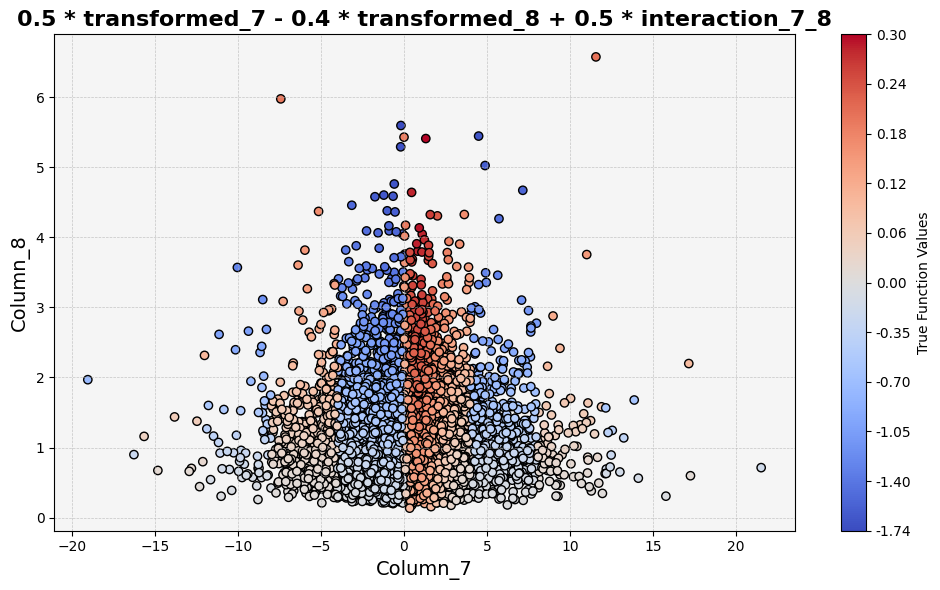

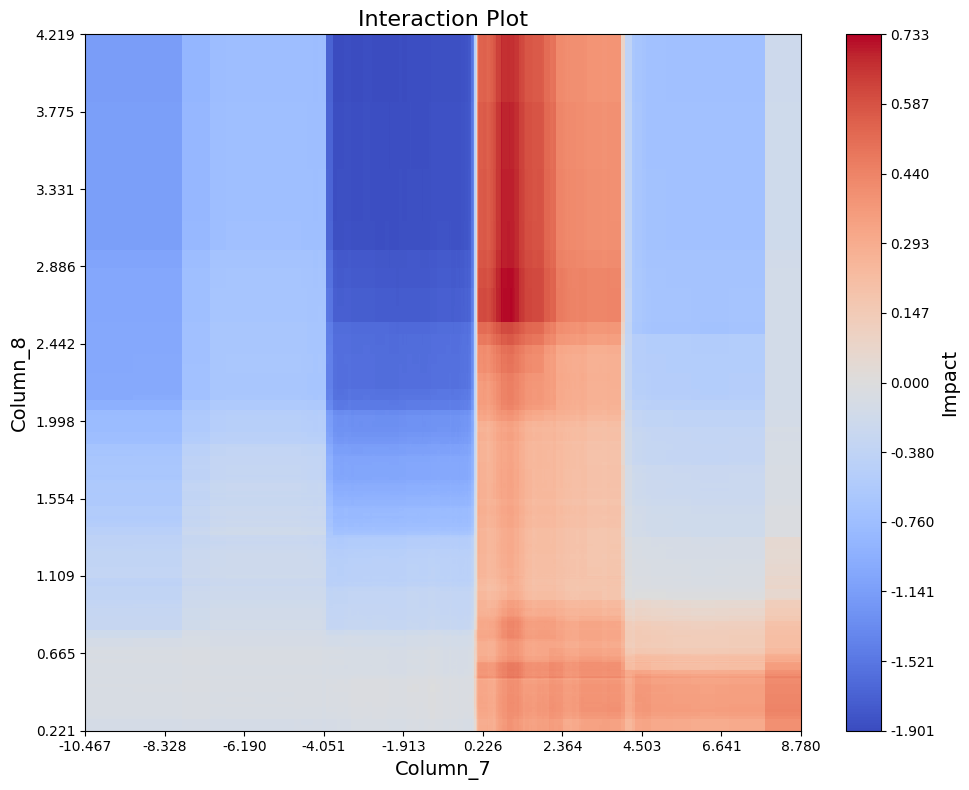

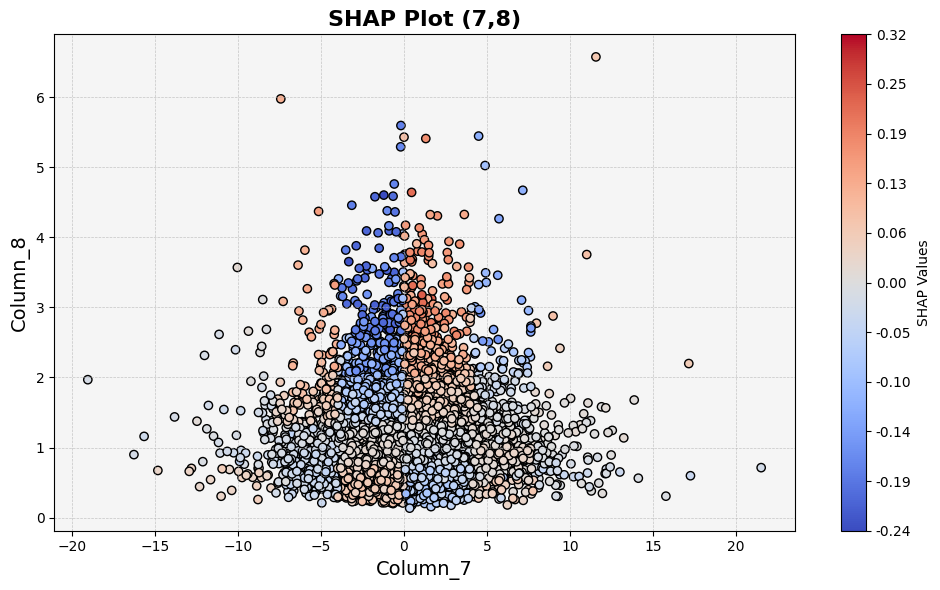

In [18]:
# Interaction Analysis: Feature 7 & Feature 8
df_78 = explainer.analyze_interaction(7, 8)
plot_scatter_chart(
    feature_7,
    feature_8,
    0.5 * transformed_7 - 0.4 * transformed_8 + 0.5 * interaction_7_8,
    x_label="Column_7",
    y_label="Column_8",
    title="0.5 * transformed_7 - 0.4 * transformed_8 + 0.5 * interaction_7_8",
    cbar_label="True Function Values",
)
interaction_plot(df_78)
plot_scatter_chart(
    feature_7,
    feature_8,
    shap_interaction_values[:, 7, 8],
    x_label="Column_7",
    y_label="Column_8",
    title="SHAP Plot (7,8)",
    cbar_label="SHAP Values",
)